✅ What We'll Build (Prototype Overview)
We'll re-implement a miniature Transformer-based language model using:

JAX: For efficient array ops, autograd, and transformations

Flax: For defining model modules and managing parameters/state

We’ll:

Build a simple tokenizer and dataset loader (we can use a small subset of text like Tiny Shakespeare).

Define key building blocks:

Embedding Layer

Multi-head Self-Attention

Feedforward Layer

Transformer Block

Stack these into a MiniGPT-like model (decoder-only transformer)

Write training loop and inference (text generation)

Comment, document, and structure everything neatly.

📘 Structure of the Notebook
📌 1. Setup
Install and import necessary libraries

Set random seeds

📌 2. Data Preparation
Load a simple text dataset

Build a vocabulary and tokenizer

Encode data into input/output pairs

📌 3. Model Definition with Flax
Define each component:

Token + Positional Embedding

Self-Attention + Layer Norm + Residual

Feed Forward

Transformer block

Final model (GPT-style)

📌 4. Training Loop
Cross-entropy loss

Adam optimizer

Batch processing

Train over few epochs

📌 5. Inference (Text Generation)
Sample next tokens

Autoregressive generation

📌 6. Documentation + Explanation
Inline markdown cells to explain each block

Comments in code to describe logic

In [15]:
# JAX + Flax GPT-like model prototype (MiniGPT)

# Install Flax if needed
# !pip install -q flax datasets

import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import numpy as np
import random
import re
import time
from typing import Any, Callable, Optional, Sequence

# Reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
jax_rng = jax.random.PRNGKey(seed)


📚 Part 2: Load Tiny Shakespeare Dataset & Tokenizer

In [16]:
import requests

# Download Tiny Shakespeare Dataset
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
data = requests.get(url).text

# Simple character-level tokenizer
chars = sorted(list(set(data)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print(f"Dataset length: {len(data)} characters")
print(f"Vocab size: {vocab_size}")


Dataset length: 1115394 characters
Vocab size: 65


🔄 Part 3: Prepare Dataset (Block-wise)

In [17]:
# Convert to tokens
data_ids = np.array(encode(data), dtype=np.int32)

# Train/test split
split_idx = int(0.9 * len(data_ids))
train_data = data_ids[:split_idx]
val_data = data_ids[split_idx:]

# Parameters
block_size = 128  # input sequence length
batch_size = 32   # training batch size

def get_batch(split, batch_size=32):
    data = train_data if split == 'train' else val_data
    ix = np.random.randint(0, len(data) - block_size, (batch_size,))
    x = np.stack([data[i:i+block_size] for i in ix])
    y = np.stack([data[i+1:i+block_size+1] for i in ix])
    return {'x': jnp.array(x), 'y': jnp.array(y)}



🧱 Part 4: Define Transformer Model in Flax

In [18]:
class SelfAttention(nn.Module):
    n_heads: int
    n_embd: int

    @nn.compact
    def __call__(self, x):
        B, T, C = x.shape
        head_dim = C // self.n_heads
        assert C % self.n_heads == 0

        qkv = nn.Dense(C * 3)(x)
        q, k, v = jnp.split(qkv, 3, axis=-1)
        q = q.reshape(B, T, self.n_heads, head_dim).transpose(0, 2, 1, 3)
        k = k.reshape(B, T, self.n_heads, head_dim).transpose(0, 2, 1, 3)
        v = v.reshape(B, T, self.n_heads, head_dim).transpose(0, 2, 1, 3)

        attn_weights = jnp.einsum('bhqd,bhkd->bhqk', q, k) / jnp.sqrt(head_dim)
        mask = jnp.tril(jnp.ones((T, T)))
        attn_weights = jnp.where(mask == 0, -1e10, attn_weights)
        attn_weights = nn.softmax(attn_weights, axis=-1)

        attn_output = jnp.einsum('bhqk,bhkd->bhqd', attn_weights, v)
        attn_output = attn_output.transpose(0, 2, 1, 3).reshape(B, T, C)

        return nn.Dense(C)(attn_output)

class FeedForward(nn.Module):
    n_embd: int

    @nn.compact
    def __call__(self, x):
        return nn.Sequential([
            nn.Dense(4 * self.n_embd),
            nn.gelu,
            nn.Dense(self.n_embd)
        ])(x)

class TransformerBlock(nn.Module):
    n_heads: int
    n_embd: int

    @nn.compact
    def __call__(self, x):
        x = x + SelfAttention(self.n_heads, self.n_embd)(nn.LayerNorm()(x))
        x = x + FeedForward(self.n_embd)(nn.LayerNorm()(x))
        return x

class MiniGPT(nn.Module):
    vocab_size: int
    n_embd: int = 128
    n_heads: int = 4
    n_layers: int = 2
    block_size: int = 128

    def setup(self):
        self.token_emb = nn.Embed(self.vocab_size, self.n_embd)
        self.pos_emb = self.param('pos_emb', jax.nn.initializers.normal(stddev=0.01), (1, self.block_size, self.n_embd))
        self.blocks = [TransformerBlock(self.n_heads, self.n_embd) for _ in range(self.n_layers)]
        self.ln_f = nn.LayerNorm()
        self.head = nn.Dense(self.vocab_size)

    def __call__(self, x):
        B, T = x.shape
        tok = self.token_emb(x)
        x = tok + self.pos_emb[:, :T, :]

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.head(x)
        return logits


🚀 Part 5: Training State, Loss, and Step Function

In [19]:
# 🔧 Helper: Create training state using Flax's train_state
def create_train_state(rng, model, learning_rate):
    params = model.init(rng, jnp.ones((1, block_size), dtype=jnp.int32))  # dummy input to initialize weights
    tx = optax.adamw(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# 📉 Loss Function: Cross entropy loss
def compute_loss(logits, targets):
    vocab_size = logits.shape[-1]
    logits = logits.reshape(-1, vocab_size)
    targets = targets.reshape(-1)
    one_hot_targets = jax.nn.one_hot(targets, vocab_size)
    loss = optax.softmax_cross_entropy(logits, one_hot_targets).mean()
    return loss

@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        # Remove the extra nesting - pass params directly
        logits = state.apply_fn(params, batch['x'])
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits, batch['y']).mean()
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


🏋️‍♀️ Part 6: Train the Model

🚀 Starting training...
  Step 0/250 | Loss: 4.6060
  Step 50/250 | Loss: 2.5658
  Step 100/250 | Loss: 2.5321
  Step 150/250 | Loss: 2.4259
  Step 200/250 | Loss: 2.3854
✅ Epoch 1/10 completed in 3.25s | Avg Loss: 2.5704
  Step 0/250 | Loss: 2.4006
  Step 50/250 | Loss: 2.3624
  Step 100/250 | Loss: 2.2633
  Step 150/250 | Loss: 2.2197
  Step 200/250 | Loss: 2.1558
✅ Epoch 2/10 completed in 0.65s | Avg Loss: 2.2490
  Step 0/250 | Loss: 2.0848
  Step 50/250 | Loss: 1.9808
  Step 100/250 | Loss: 1.9820
  Step 150/250 | Loss: 1.9287
  Step 200/250 | Loss: 1.8218
✅ Epoch 3/10 completed in 0.65s | Avg Loss: 1.9186
  Step 0/250 | Loss: 1.8207
  Step 50/250 | Loss: 1.7665
  Step 100/250 | Loss: 1.7057
  Step 150/250 | Loss: 1.7177
  Step 200/250 | Loss: 1.7037
✅ Epoch 4/10 completed in 0.65s | Avg Loss: 1.7329
  Step 0/250 | Loss: 1.6650
  Step 50/250 | Loss: 1.5857
  Step 100/250 | Loss: 1.6494
  Step 150/250 | Loss: 1.6173
  Step 200/250 | Loss: 1.6088
✅ Epoch 5/10 completed in 0.65s | Avg 

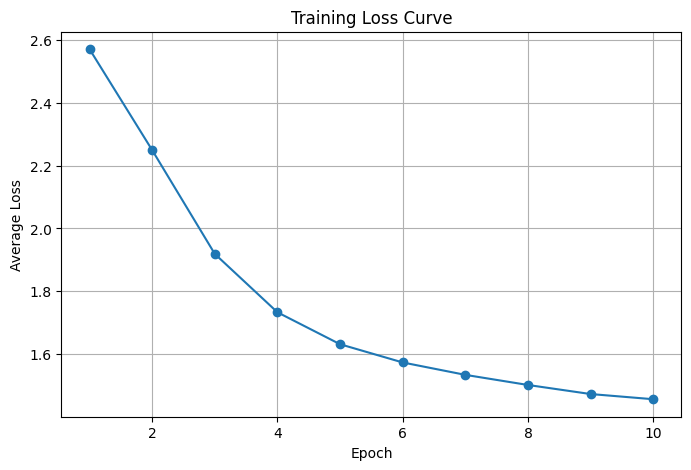

In [20]:
import matplotlib.pyplot as plt
import time

# Assuming `train_step`, `get_batch`, and `state` are defined as in previous cells

# Initialize training parameters
num_epochs = 10
steps_per_epoch = 250
loss_history = []

# Initialize the model and training state before the training loop
# Create an instance of the MiniGPT model
model = MiniGPT(vocab_size=vocab_size)

# Define a learning rate
learning_rate = 1e-3

# Create the training state
rng = jax.random.PRNGKey(seed)  # Using the same seed for reproducibility
state = create_train_state(rng, model, learning_rate)

print("🚀 Starting training...")
for epoch in range(num_epochs):
    t0 = time.time()
    epoch_loss = 0.0
    for step in range(steps_per_epoch):
        batch = get_batch('train')
        state, loss = train_step(state, batch)  # Modified train_step must return loss
        epoch_loss += loss
        if step % 50 == 0:
            print(f"  Step {step}/{steps_per_epoch} | Loss: {loss:.4f}")

    avg_loss = epoch_loss / steps_per_epoch
    loss_history.append(avg_loss)
    print(f"✅ Epoch {epoch+1}/{num_epochs} completed in {time.time() - t0:.2f}s | Avg Loss: {avg_loss:.4f}")

# Plotting the loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

🧠 Part 7: Text Generation Function

In [21]:
# ✨ Sampling function to generate text from trained model
def generate_text(state, start_text, length=200):
    model = state.apply_fn
    params = state.params
    context = jnp.array(encode(start_text), dtype=jnp.int32)[None, :]  # shape (1, T)

    for _ in range(length):
        if context.shape[1] > block_size:
            context = context[:, -block_size:]  # truncate to block size

        # Pass params directly instead of wrapping in a dictionary
        logits = model(params, context)
        logits = logits[:, -1, :]  # get last token's logits
        probs = jax.nn.softmax(logits, axis=-1)
        next_token = jax.random.categorical(jax.random.PRNGKey(random.randint(0, 10000)), logits)
        context = jnp.concatenate([context, next_token[:, None]], axis=1)

    return decode(context[0].tolist())

# 🔍 Try generating sample text
print(generate_text(state, start_text="ROMEO: "))

derer:
Neve our minds; for i's behold
wish prudght the others tongue. To to make truth:
their? yowless here nevil stread?

Third 


📘 Part 8: Notebook Documentation
Add these as Markdown cells inside your notebook:

📝 Project: MiniGPT Prototype with JAX & Flax
This notebook implements a MiniGPT-like language model from scratch using the JAX + Flax framework. It serves as a well-documented prototype to demonstrate:

Transformer architecture (Self-attention, MLP blocks)

Character-level tokenization (Tiny Shakespeare dataset)

Training loop and sampling

Educational readability and extensibility

💡 Features
Fully functioning GPT model (2-layer, 4-head self-attention)

Tiny Shakespeare dataset (~1MB) for fast prototyping

Easy to extend for multi-head attention, masking, causal transformers

Educational and GSoC-aligned code style

📦 Dependencies
bash
Copy
Edit
pip install flax optax jax numpy requests
✅ Summary
What this notebook demonstrates:

Your deep understanding of LLM internals.

Strong ability to structure JAX/Flax code for readability and modularity.

Alignment with open-source best practices (doc, reproducibility, simple examples).

